In [10]:
from models.module import Encoder, Decoder
from models.autoencoder import AutoencoderKL
from omegaconf import OmegaConf
import numpy as np
import torch
from models.util import s2c, c2s
from CS492D_project.data.dataset import ShapeNetDataModule2, get_data_iterator, tensor_to_pil_image
from einops import rearrange

In [2]:
vae_config = OmegaConf.load('configs/vae/config_nodisc_kl1e-6.yaml')

autoencoder = AutoencoderKL(ddconfig=vae_config.model.params.ddconfig,
                            disc_config=vae_config.model.params.disc_config,
                                kl_weight=vae_config.model.params.kl_weight, 
                                embed_dim=vae_config.model.params.embed_dim,
                                learning_rate=vae_config.model.learning_rate)

autoencoder.init_from_ckpt('logs/train_vae_11-14-101249/epoch=99-step=12400.ckpt')
autoencoder.to('cuda:0')
autoencoder.eval()
print('check')

Working with z of shape (1, 8, 8, 8, 8) = 4096 dimensions.


/data1/kietngt00/CS429D_project/models/autoencoder.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(path, map_location="cpu")["state_dict"]


Restored from logs/train_vae_11-14-101249/epoch=99-step=12400.ckpt
check


In [99]:
# load the preprocessed voxel data.
ds_module = ShapeNetDataModule2(
        "./data",
        target_categories='chair',
        batch_size=vae_config.data.batch_size,
        num_workers=vae_config.data.num_workers,
    )
val_dl = ds_module.val_dataloader()
batch = next(iter(val_dl))

In [100]:
inputs = batch[0]
inputs = s2c(inputs.unsqueeze(1)).to('cuda:0')
inputs.shape

torch.Size([8, 8, 64, 64, 64])

In [101]:
with torch.no_grad():
    rec, posterior = autoencoder(inputs)
    sample = c2s(autoencoder.decode(torch.randn_like(posterior.sample())))


In [102]:
sparse_rec = rearrange(s2c(c2s(rec), 2, 2, 2), 'b c h w d -> b h w d c')
top1_values, top1_indices = torch.topk(sparse_rec, 1, dim=-1)
sparse_rec = torch.zeros_like(sparse_rec).scatter_(-1, top1_indices, top1_values)
sparse_rec = rearrange(sparse_rec, 'b h w d c -> b c h w d')

In [83]:
sparse_rec.shape

torch.Size([8, 64, 32, 32, 32])

In [6]:
import numpy as np
import torch
import h5py
from load_data import voxelize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])
    
    ax.axis("off")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()
    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

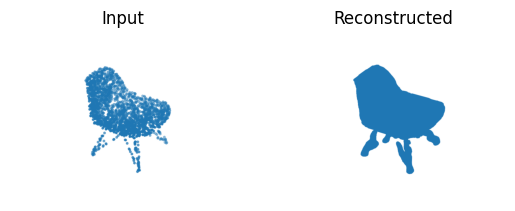

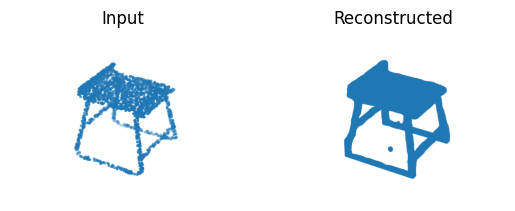

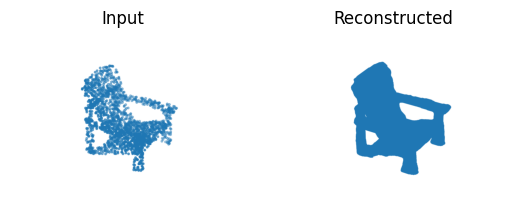

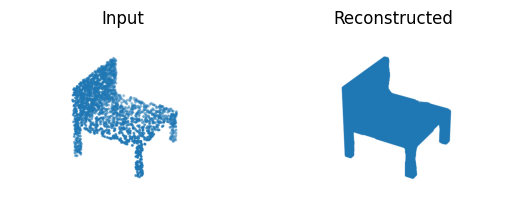

In [103]:
for i in range(4):
    rec_voxel =  sparse_rec[i]
    input = inputs[i]  
    rec_voxel = c2s(rec_voxel.unsqueeze(0), 2, 2, 2).squeeze().cpu().numpy()
    img1 = visualize_voxel(rec_voxel > 0.5)
    input = c2s(input.unsqueeze(0)).squeeze().cpu().numpy()
    img2 = visualize_voxel(input)
    plt.subplot(1, 2, 1)
    plt.title('Input')
    plt.imshow(img2)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img1)
    plt.title('Reconstructed')
    plt.axis('off')
    plt.show()

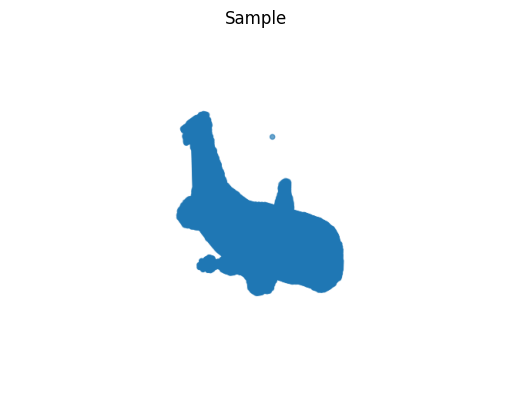

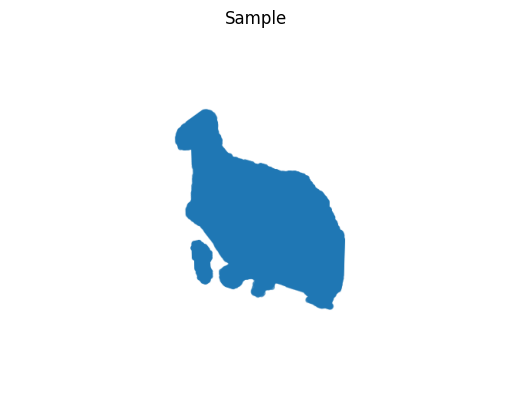

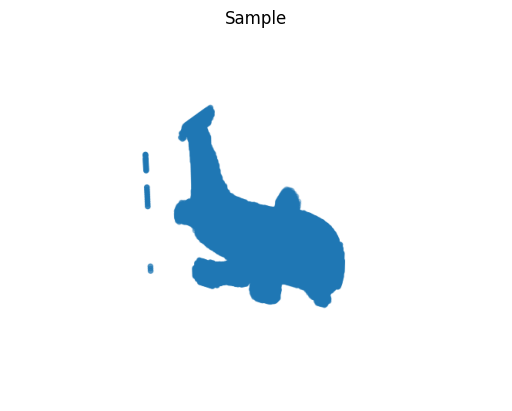

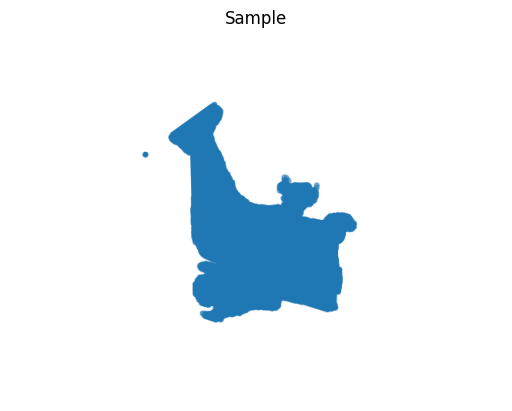

In [8]:
for i in range(4,8):
    sample_voxel =  sample[i]
    sample_voxel = sample_voxel.squeeze().cpu().numpy()
    img1 = visualize_voxel(sample_voxel > 0.5)
    plt.title('Sample')
    plt.imshow(img1)
    plt.axis('off')
    plt.show()
    